In [1]:
import torch
from torch import nn

# Exercise 1

### Generate the following dataset: yi = sin(xi) cos(xi) + xi^3 + ∈, where E obeys a normal distribution with 0 mean and standard deviation 0.1. The number of training/testing examples is 30. Plot the prediction for this regression problem using Nadaraya-Watson kernel regression nonparametric attention model, and also plot the attention heatmap

## Data

In [2]:
def f(x: torch.Tensor):
    return torch.sin(x) * torch.cos(x) + x**3


In [11]:
n_train = 30
x_train, _ = torch.sort(torch.rand(n_train) * 30)

In [12]:
eps = torch.normal(0, 0.1, size=(n_train,))
y_train = f(x_train) + eps

In [13]:
n_test = 30
x_test = torch.arange(0, 30, 1)
y_test = f(x_test)

## Plot

In [16]:
from matplotlib import pyplot as plt


def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_test, label='Truth')
    plt.plot(x_test, y_hat, label='Pred')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.plot(x_train, y_train, 'o', alpha=0.5);

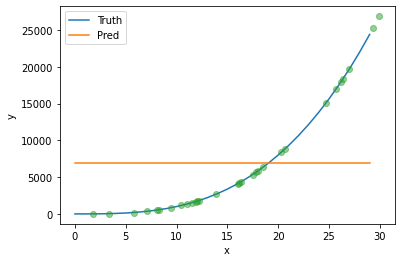

In [17]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

# Exercise 2

### Train an encoder and a decoder with attention mechanism for machine translation. The attention mechanism is similar to Bahdanau attention excepting the attention weight a that will be computed using the scaled dot-product attention. The dataset is the English-French dataset from the laboratory. The embedding size, number of hidden and the dropout probability is 16, 20 and 50%, respectively. Train the model for 200 epochs and plot the training loss.


## Data

In [36]:
import collections
import os
from typing import Literal
import zipfile

import requests

def download(url: str) -> str:
    """Download a file, return the local filename."""
    file_path = '../data/' + url.split('/')[-1]
    if os.path.exists(file_path):
        return file_path
    
    print(f'Downloading {file_path} from {url}...')
    res = requests.get(url, stream=True, verify=True)
    with open(file_path, 'wb') as f:
        f.write(res.content)
    return file_path

def download_extract(url: str) -> str:
    """Download and extract a zip file."""
    file_path = download(url)
    fp = zipfile.ZipFile(file_path, 'r')
    
    data_folder_path = os.path.dirname(file_path)
    fp.extractall(data_folder_path)
    
    extracted_folder_path = os.path.splitext(file_path)[0]
    return extracted_folder_path

def read_data_nmt() -> str:
    """Load the English-French dataset."""
    folder = download_extract('http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip')
    with open(folder + '/fra.txt', 'r') as f:
        return f.read()


In [60]:
from torch.utils.data import DataLoader

class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens: list[str]=[], min_freq=0, reserved_tokens: list[str]=[]):
        # Sort according to frequencies
        counter = collections.Counter(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens + [token for token, freq in self._token_freqs if freq >= min_freq]
        self.token_to_idx =  {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self) -> int:
        return len(self.idx_to_token)

    def __getitem__(self, tokens: str | list[str]) -> int | list[int]:
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.token_to_idx.get(token, self.unk) for token in tokens]

    def to_tokens(self, indices: int | list[int]) -> str | list[str]:
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self) -> Literal[0]:  # Index for the unknown token
        return 0

    @property
    def token_freqs(self) -> list[tuple[str, int]]:  # Token frequencies
        return self._token_freqs

def preprocess_nmt(text: str) -> str:
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text: str, num_examples: int):
    """Tokenize the English-French dataset."""
    source: list[str] = []
    target: list[str] = []
    for i, line in enumerate(text.split('\n')):
        if i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.extend(parts[0].split(' '))
            target.extend(parts[1].split(' '))
    return source, target

def truncate_pad(line, num_steps: int, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

def build_array_nmt(lines: list[str], vocab: Vocab, num_steps: int):
    """Transform text sequences of machine translation into mini-batches."""
    lines = [vocab[l] for l in lines]
    print(lines)
    lines = [l + [vocab['<eos>']] for l in lines]
    
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    
    return array, valid_len

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

def load_data_nmt(batch_size: int, num_steps: int, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [55]:
text = preprocess_nmt(read_data_nmt())
source, target = tokenize_nmt(text, 654)

In [56]:
src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])

In [61]:
src_array, src_valid_len = build_array_nmt(source, src_vocab, 654)

[9, 4, 119, 4, 59, 6, 59, 6, 45, 11, 0, 6, 73, 6, 39, 6, 0, 4, 64, 6, 64, 6, 64, 6, 120, 6, 120, 6, 9, 22, 4, 9, 22, 4, 9, 22, 4, 121, 6, 121, 6, 5, 122, 4, 5, 33, 4, 5, 23, 6, 5, 23, 6, 5, 23, 4, 0, 26, 6, 123, 6, 123, 6, 74, 6, 74, 6, 74, 6, 74, 6, 13, 14, 4, 9, 75, 4, 9, 75, 4, 9, 75, 4, 34, 8, 6, 34, 8, 6, 34, 8, 11, 34, 8, 11, 34, 8, 11, 124, 46, 4, 124, 46, 4, 96, 12, 4, 96, 12, 4, 5, 97, 4, 5, 97, 4, 5, 125, 4, 5, 76, 4, 5, 76, 4, 5, 19, 4, 5, 126, 4, 7, 0, 4, 7, 77, 4, 7, 77, 4, 0, 4, 26, 35, 6, 26, 35, 6, 26, 35, 6, 26, 35, 6, 26, 35, 6, 26, 35, 6, 26, 35, 6, 26, 35, 6, 26, 35, 6, 98, 11, 98, 11, 98, 11, 0, 4, 17, 33, 4, 17, 23, 4, 17, 23, 4, 17, 23, 4, 17, 23, 4, 78, 10, 4, 0, 6, 15, 47, 4, 15, 47, 4, 15, 47, 4, 15, 65, 4, 15, 36, 4, 15, 36, 4, 15, 36, 4, 15, 36, 4, 15, 36, 4, 15, 36, 4, 15, 0, 4, 15, 29, 4, 15, 29, 4, 15, 29, 4, 15, 29, 4, 15, 29, 4, 15, 29, 4, 0, 8, 4, 48, 12, 4, 48, 12, 4, 48, 25, 4, 48, 25, 4, 16, 46, 4, 16, 46, 4, 16, 46, 4, 16, 46, 4, 16, 22, 6, 16, 22,

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [52]:
# print(text)
print(source)
print(target)

[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?'], ['wow', '!'], ['fire', '!'], ['help', '!'], ['jump', '.'], ['stop', '!'], ['stop', '!'], ['stop', '!'], ['wait', '!'], ['wait', '!'], ['go', 'on', '.'], ['go', 'on', '.'], ['go', 'on', '.'], ['hello', '!'], ['hello', '!'], ['i', 'see', '.'], ['i', 'try', '.'], ['i', 'won', '!'], ['i', 'won', '!'], ['i', 'won', '.'], ['oh', 'no', '!'], ['attack', '!'], ['attack', '!'], ['cheers', '!'], ['cheers', '!'], ['cheers', '!'], ['cheers', '!'], ['get', 'up', '.'], ['go', 'now', '.'], ['go', 'now', '.'], ['go', 'now', '.'], ['got', 'it', '!'], ['got', 'it', '!'], ['got', 'it', '?'], ['got', 'it', '?'], ['got', 'it', '?'], ['hop', 'in', '.'], ['hop', 'in', '.'], ['hug', 'me', '.'], ['hug', 'me', '.'], ['i', 'fell', '.'], ['i', 'fell', '.'], ['i', 'know', '.'], ['i', 'left', '.'], ['i', 'left', '.'], ['i', 'lost', '.'], ['i', 'paid', '.'], ["i'm", '19', '.'], ["i'm", 'ok', '.'], ["i'm", 'ok', '.'], ['listen', '.'], ['no', 'way', '

In [39]:
batch_size = 64
num_steps = 10
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

TypeError: unsupported operand type(s) for +: 'int' and 'list'

## Encoder and Decoder

In [ ]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [ ]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return F.softmax(X.reshape(shape), dim=-1)

In [ ]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries` is: (`batch_size`, no. 
        # of queries, 1, `num_hiddens`) and shape of `keys` is: (`batch_size`, 
        # 1, no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores` is:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values` is: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError
    
class AttentionDecoder(Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError
    
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs` is: (`num_steps`, `batch_size`, `num_hiddens`).
        # Shape of `hidden_state[0]` is: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of `enc_outputs` is: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]` is: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X` is: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of `query` is: (`batch_size`, 1, `num_hiddens`)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of `context` is: (`batch_size`, 1, `num_hiddens`)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of `outputs` is:
        # (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

class Seq2SeqEncoder(Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [2]:
import collections
import os
import random
import re
from typing import Literal

import requests

def download(url: str) -> str:
    """Download a file, return the local filename."""
    file_path = '../data/' + url.split('/')[-1]
    if os.path.exists(file_path):
        return file_path
    
    print(f'Downloading {file_path} from {url}...')
    res = requests.get(url, stream=True, verify=True)
    with open(file_path, 'wb') as f:
        f.write(res.content)
    return file_path

def read_time_machine() -> list[str]:
    """Load the time machine dataset into a list of text lines."""
    file = download('http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt')
    with open(file, 'r') as f:
        lines = f.readlines()
    
    lines_transformed = [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
    return [line for line in lines_transformed if line]

def tokenize(lines: list[str], token: Literal['word', 'char']='word') -> list[str]:
    """Split text lines into word or character tokens."""
    if token == 'word':
        tokens: list[list[str]] =  [line.split() for line in lines]
    else:
        tokens: list[list[str]] = [list(line) for line in lines]
    return [token for sublist in tokens for token in sublist]
    
def count_corpus(tokens: list[str]) -> collections.Counter[str]:
    """Count token frequencies."""
    return collections.Counter(tokens)

In [3]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens: list[str]=[], min_freq=0, reserved_tokens: list[str]=[]):
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens + [token for token, freq in self._token_freqs if freq >= min_freq]
        self.token_to_idx =  {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self) -> int:
        return len(self.idx_to_token)

    def __getitem__(self, tokens: str | list[str]) -> int | list[int]:
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.token_to_idx.get(token, self.unk) for token in tokens]

    def to_tokens(self, indices: int | list[int]) -> str | list[str]:
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self) -> Literal[0]:  # Index for the unknown token
        return 0

    @property
    def token_freqs(self) -> list[tuple[str, int]]:  # Token frequencies
        return self._token_freqs


class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size: int, num_steps: int, max_tokens: int=10000):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.vocab = self.generate_vocab()
        self.corpus = self.generate_corpus(max_tokens)
        
    def generate_vocab(self) -> Vocab:
        lines = read_time_machine()
        tokens = tokenize(lines, 'char')
        return Vocab(tokens)
    
    def generate_corpus(self, max_tokens):
        tokens = tokenize(read_time_machine(), 'char')
        corpus = [self.vocab[token] for line in tokens for token in line]
        return corpus[:max_tokens]

    def __iter__(self):
        """Generate a mini-batch of subsequences using sequential partitioning."""
        # Start with a random offset to partition a sequence
        offset = random.randint(0, self.num_steps)
        num_tokens = ((len(self.corpus) - offset - 1) // self.batch_size) * self.batch_size
        Xs = torch.tensor(self.corpus[offset: offset + num_tokens])
        Ys = torch.tensor(self.corpus[offset + 1: offset + 1 + num_tokens])
        Xs, Ys = Xs.reshape(self.batch_size, -1), Ys.reshape(self.batch_size, -1)
        num_batches = Xs.shape[1] // self.num_steps
        for i in range(0, self.num_steps * num_batches, self.num_steps):
            X = Xs[:, i: i + self.num_steps]
            Y = Ys[:, i: i + self.num_steps]
            yield X, Y

In [4]:
batch = 50
steps = 10

In [5]:
train_iter = SeqDataLoader(batch, steps)
vocab = train_iter.vocab

In [ ]:
input_size = vocab_size = len(vocab)
hidden_size = 64

In [ ]:
lstm_layer = nn.LSTM(input_size, hidden_size)
net = nn.RNN(lstm_layer, vocab_size)

In [ ]:
perplexities = train(net, train_iter, vocab, lr=1, num_epochs=100, device)